# Results Regression

In [1]:
import os
import sys

sys.path.append('../')

import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter
import langdetect
import random
import re
from sklearn.model_selection import train_test_split

from utils.preprocessing import clean_dataset

In [2]:
DATA_DIR = "../data"
data_train = pd.read_csv(os.path.join(DATA_DIR, "train_cleaned.csv"), na_filter=False)
data_val = pd.read_csv(os.path.join(DATA_DIR, "val_cleaned.csv"), na_filter=False)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures
from transformers import TrainingArguments
from transformers import Trainer
import torch
from datasets import load_metric

from utils.classes import SentimentDataset
from utils.preprocessing import make_labels, tokenize

In [4]:
MODEL = "xlm-roberta-base"
MODEL_PRETRAINED = "../models/xlm_roberta_regress/checkpoint-3516"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PRETRAINED, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [5]:
X_train = tokenize(tokenizer, data_train.content)
X_val = tokenize(tokenizer, data_val.content)
y_train = data_train.sentiment
y_val = data_val.sentiment

In [6]:
y_train_labels = make_labels(y_train, regress=True)
y_val_labels = make_labels(y_val, regress=True)

In [7]:
train_dataset_torch = SentimentDataset(X_train, y_train_labels)
val_dataset_torch = SentimentDataset(X_val, y_val_labels)

In [8]:
metric = load_metric("accuracy")

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [10]:
training_args = TrainingArguments(
    "bert_base_uncased_classif",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=32,
    fp16 = True,
    fp16_opt_level = 'O1',
    evaluation_strategy = 'epoch',
    save_strategy="epoch",
    num_train_epochs=4
    
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_torch,
    eval_dataset=val_dataset_torch,
    compute_metrics=compute_metrics
)

Using amp fp16 backend


In [12]:
train_predictions = trainer.predict(train_dataset_torch)

***** Running Prediction *****
  Num examples = 18750
  Batch size = 32


### Analysis of the test results for each class

In [13]:
train_negative = data_train[data_train.sentiment=="negative"]
train_positive = data_train[data_train.sentiment=="positive"]
train_neutral = data_train[data_train.sentiment=="neutral"]

In [14]:
x_negative = tokenize(tokenizer, train_negative.content)
x_positive = tokenize(tokenizer, train_positive.content)
x_neutral = tokenize(tokenizer, train_neutral.content)

In [15]:
y_negative = make_labels(train_negative.sentiment, regress=True)
y_positive = make_labels(train_positive.sentiment, regress=True)
y_neutral = make_labels(train_neutral.sentiment, regress=True)

In [16]:
torch_negative = SentimentDataset(x_negative, y_negative)
torch_positive = SentimentDataset(x_positive, y_positive)
torch_neutral = SentimentDataset(x_neutral, y_neutral)

In [17]:
preds_negative = trainer.predict(torch_negative)
preds_positive = trainer.predict(torch_positive)
preds_neutral = trainer.predict(torch_neutral)

***** Running Prediction *****
  Num examples = 5860
  Batch size = 32
***** Running Prediction *****
  Num examples = 6193
  Batch size = 32
***** Running Prediction *****
  Num examples = 6696
  Batch size = 32


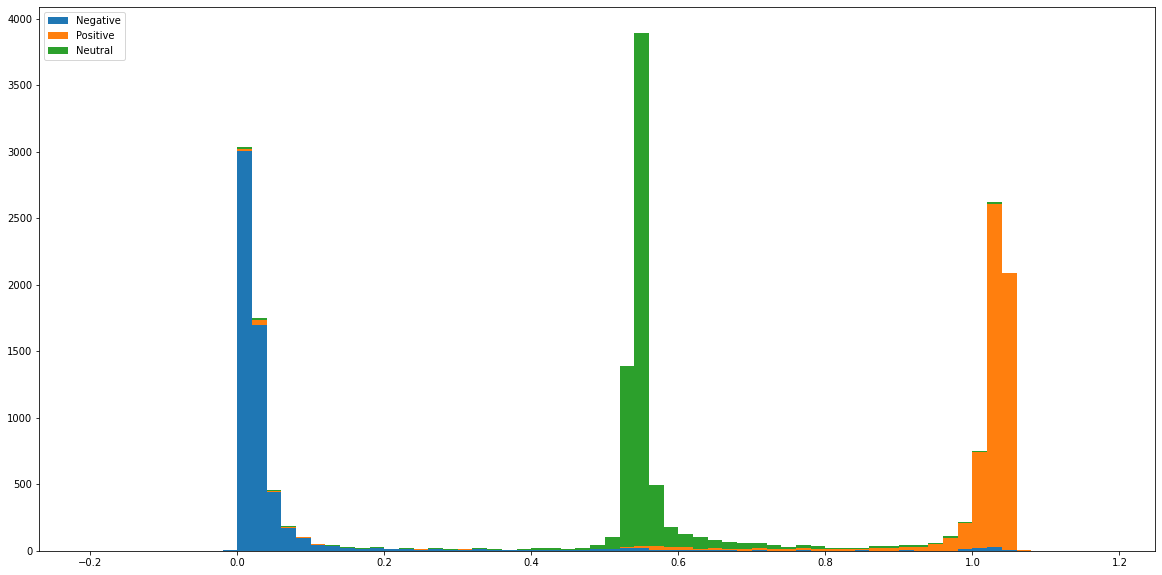

In [18]:
plt.figure(figsize=(20, 10))
plt.hist([preds_negative.predictions.flatten(), preds_positive.predictions.flatten(), preds_neutral.predictions.flatten()], bins = np.arange(-.2, 1.2, 0.02),label=["Negative", "Positive", "Neutral"], stacked=True)
plt.legend(loc="upper left")
plt.show()

We can observe that the regression worked well, however some are still classified as to the opposite sentiment.

### Let's compute the bounds to classify the data using the regression result

Here we are looking for the best higher and lower bounds that maximize the train accuracy

In [19]:
def compute_predicted_labels(predictions, lower=.25, higher=.75):
    predicted_labels = [0 if prediction < lower else 2 if prediction > higher else 1 for prediction in predictions]
    return predicted_labels

In [20]:
def compute_best_lower_bound(predictions, highest = .75):
    accs = []
    bounds = []
    for i in np.arange(0, .66, 0.01):
        accs.append(metric.compute(predictions=compute_predicted_labels(predictions.predictions, i, highest), references=compute_predicted_labels(predictions.label_ids))["accuracy"])
        bounds.append(i)
    print(f"Max = {bounds[np.argmax(accs)]}")

    plt.plot(bounds, accs)
    return bounds[np.argmax(accs)]

In [21]:
def compute_best_higher_bound(predictions, lowest= .25):
    accs = []
    bounds = []
    for i in np.arange(.4, 1, 0.01):
        accs.append(metric.compute(predictions=compute_predicted_labels(predictions.predictions, lowest, i), references=compute_predicted_labels(predictions.label_ids))["accuracy"])
        bounds.append(i)

    print(f"Max = {bounds[np.argmax(accs)]}")
    plt.plot(bounds, accs)
    return bounds[np.argmax(accs)]

Max = 0.8100000000000004


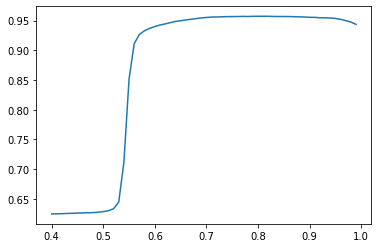

In [22]:
higher = compute_best_higher_bound(train_predictions)

Max = 0.34


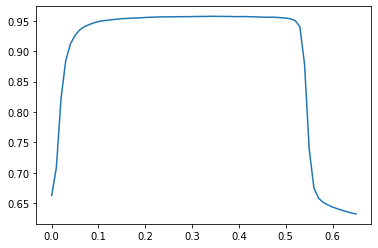

In [23]:
lower = compute_best_lower_bound(train_predictions)

In [24]:
val_predictions = trainer.predict(val_dataset_torch)

***** Running Prediction *****
  Num examples = 6250
  Batch size = 32


### Results

In [25]:
predicted_labels_adjusted = compute_predicted_labels(val_predictions.predictions, lower, higher)

In [26]:
metric.compute(predictions=predicted_labels_adjusted, references=compute_predicted_labels(val_predictions.label_ids))

{'accuracy': 0.84624}

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
predicted_labels = compute_predicted_labels(val_predictions.label_ids)

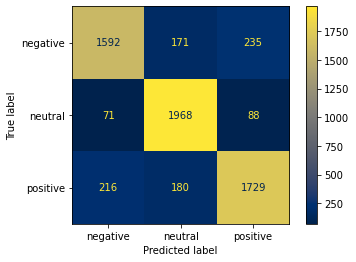

In [29]:
conf_matrix = confusion_matrix(predicted_labels, predicted_labels_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["negative", "neutral", "positive"],)
disp.plot( cmap="cividis")

In [30]:
data_val = data_val.assign(predictions=pd.Series(predicted_labels_adjusted).values)

In [31]:
data_val = data_val.assign(label=pd.Series(compute_predicted_labels(val_predictions.label_ids)).values)

In [32]:
data_val

,Unnamed: 0,content,sentiment,language,predictions,label
0,19828,Marcelo Rebelo de Sousa e João Lourenço reunid...,neutral,pt,1,1
1,13131,Did you notice that zero has a karambit knife ...,positive,en,1,2
2,17486,"Page invita a Iceta a defenderle ""ante tanto i...",neutral,es,1,1
3,5955,Movimento de Mulheres cria aplicação para tele...,neutral,pt,1,1
4,8126,"GLOBAL MARKETS-US stocks rise, push Dow to rec...",neutral,en,1,1
...,...,...,...,...,...,...
6245,21682,@ 7anno他是我朋友之一的儿子,positive,zh-cn,2,2
6246,12555,Kohleausstieg lässt Hausmüllentsorgung möglich...,neutral,de,1,1
6247,16937,Y’a pas de confort.,negative,es,0,0
6248,6833,küsülülüyə əvvəlində biz zahirən bağlı obrazl...,negative,tr,2,0


In [33]:
results_by_language = []
for language in set(data_val.language):
    data = data_val[data_val.language == language]
    results_by_language.append((language,  metric.compute(predictions=data.predictions, references=data.label)["accuracy"], len(data)))
results_by_language = pd.DataFrame(results_by_language, columns=["language", "accuracy", "size"]).sort_values("size")[::-1]

In [34]:
results_by_language

,language,accuracy,size
4,en,0.813627,998
32,id,0.880000,800
42,ru,0.930643,793
25,ar,0.857143,462
13,fr,0.863747,411
43,es,0.882540,315
44,pt,0.909396,298
11,ko,0.814545,275
15,zh-cn,0.754545,220
49,ja,0.861878,181


## Results on the main languages

In [35]:
main_languages = ["en", "id", "ru", "ar", "fr", "es", "pt", "ko", "zh-cn", "ja", "de", "it", "th", "tr"]

In [36]:
 metric.compute(predictions=data_val[data_val.language.isin(main_languages)].predictions, references=data_val[data_val.language.isin(main_languages)].label)

{'accuracy': 0.859602142310635}

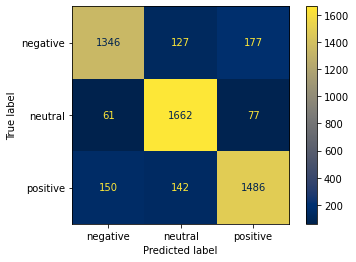

In [37]:
conf_matrix = confusion_matrix(data_val[data_val.language.isin(main_languages)].label, data_val[data_val.language.isin(main_languages)].predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["negative", "neutral", "positive"],)
disp.plot( cmap="cividis")

### Positive classified as negative

In [38]:
for sentence in data_val[data_val.language=="en"][data_val.label==2][data_val.predictions==0].content:
    print(sentence)

Anime Saturday about to start. New episode of bleach.  Yea 
So tired. Finally getting some sleep. Nighty 
If it was up to me I would give more berry's it is tottly not cool having to buy your eggs with berries I mean for real not cool update it a lift will you.
핸드폰 전체 세팅에서 말고 앱 내에서 개인이나 단톡방 알림끄기하면 소리는 안나는데 배너는 계속떠요. 아예 메세지가 안온거처럼 안뜨고 들어갈경우에만 받은 메세지가 보였으면 좋겠네요 Once i turn off the notification of a person/ group, as long as I don't check messages, i wish i do not see any notification(banner) and also number of accumulated messages on the list.
8 cm dilated and her water just broke. Getting closer 
going to rehearsals! 
tɦɨs aքք ɨs ʋɛʀʏ ɢօօɖ tօ ʊsɛ
Tomorrow Demi in Madrid  I didn't win the concert to meet her LOL!
 typical metro, can't even get that right. 
chrome falling off or missing on a steel stand and poor stainless steel quality made utensils , returned for refund
 I am in bed.  
For No Reason Pou Can Die.
Addictingd
I love Birkenstock Arizona sandals and have been wearing them for

C:\Users\Louis\AppData\Local\Temp/ipykernel_25588/4078927634.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sentence in data_val[data_val.language=="en"][data_val.label==2][data_val.predictions==0].content:
